#  let's make sure you've got the datasets

herem we are basically dealing with shapefiles (.shp). It helps us a lot to load geometry data since data is stored with spatial index and divided in multiple files. We dont need to know what it exactly is, but you can check it out later:

https://en.wikipedia.org/wiki/Shapefile


## Shapefiles should be at the folder project/data. Here it goes the urls we need:

trees:
* git version (mn only)
* https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/pi5s-9p35/data

neighbourhoods:

* git version (mn only)
* https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nynta_17a.zip

streets base lines:

* git version (mn only)
* https://data.cityofnewyork.us/City-Government/NYC-Street-Centerline-CSCL-/exjm-f27b/data


# some tricks to make it easier to reload the modules while coding


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## loading base modules 

In [2]:
import geopandas as gpd
import pandas as pd
import fiona
from shapely.geometry import Point, MultiLineString, LineString, Polygon, box
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [10,10]

## loading the datasets (takes a while to load at the first time..)

In [8]:
from functools import partial
import pyproj
from shapely.ops import transform

## get and filter original data (we dont need this anymore) 
# villagesdf = gpd.GeoDataFrame.from_file('data/nynta_17a/nynta.shp', driver='ESRI Shapefile')
# streets = gpd.read_file('data/cscl/geo_export_9b5ba191-3196-4816-bca5-541f0532f2c3.shp', driver='ESRI Shapefile')
# trees = g## let's constraint our working data to Manhattan only (we dont need this right now)pd.read_file('data/trees/geo_export_a41c752c-f3ec-4fba-9962-53d4effb2958.shp', driver='ESRI Shapefile')

## let's constraint our working data to Manhattan only (we dont need this right now)
# villagesmn = villagesdf[villagesdf.BoroCode==1]
# streetsmn = streets[streets.borocode=='1']
# treesmn = trees[trees.borocode=='1']

## exporting back to files
# villagesmn.to_file('data/villages-mn.shp')
# streetsmn.to_file('data/streets-mn.shp')
# treesmn.to_file('data/trees-mn.shp')

villagesdf = gpd.GeoDataFrame.from_file('data/villages-mn.shp', driver='ESRI Shapefile')
streets = gpd.read_file('data/streets-mn.shp', driver='ESRI Shapefile')
trees = gpd.read_file('data/trees-mn.shp', driver='ESRI Shapefile')

## converting CRS to UTM ( "flat" the maps, thus spatial queries get much easier)

In [11]:
villagesdf = villagesdf.to_crs(epsg=26918)
streets = streets.to_crs(epsg=26918)
trees = trees.to_crs(epsg=26918)

## plotting trees and streets in MN borough 
### as an example, let's quick sample the entire datasets thus the plot runs faster for now

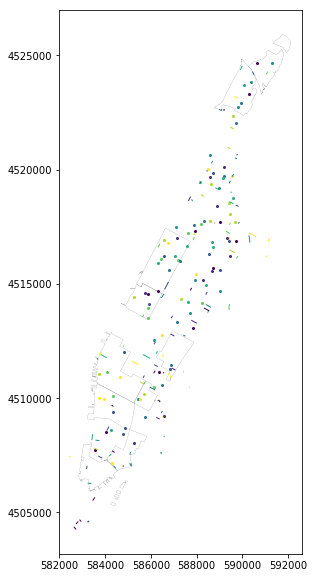

In [18]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
villagesdf.sample(10).plot(ax=ax, color="white", linewidth=.1)
trees.sample(100).plot(ax=ax)
streets.sample(100).plot(ax=ax)

## let's aggregate the number of trees by neighbourhoods

### .. to be continued 